In [1]:
clear

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
import time

# plt.rcParams["figure.figsize"] = (50,3)

In [3]:
def stream(nN, nE, nS, nW, nNE, nSE, nSW, nNW):
    
    # Stream all internal cells
    for x in range(0, width-1):
        for y in range(1, height-1):
            # Movement north (Northwest corner)
            nN[y*width + x] = nN[y*width + x + width]
            # Movement northwest (Northwest corner)
            nNW[y*width + x] = nNW[y*width + x + width + 1]
            # Movement west (Northwest corner)
            nW[y*width + x] = nW[y*width + x + 1]
            # Movement south (Southwest corner)
            nS[(height-y-1)*width + x] = nS[(height-y-1-1)*width + x]
            # Movement southwest (Southwest corner)
            nSW[(height-y-1)*width + x] = nSW[(height-y-1-1)*width + x + 1]
            # Movement east (Northeast corner)
            nE[y*width + (width-x-1)] = nE[y*width + (width-(x+1)-1)]
            # Movement northeast (Northeast corner)
            nNE[y*width + (width-x-1)] = nNE[y*width + width + (width-(x+1)-1)]
            # Movement southeast (Southeast corner)
            nSE[(height-y-1)*width + (width-x-1)] = nSE[(height-y-1-1)*width +
                                                        (width-(x+1)-1)]  
            
    # Tidy up the edges
    x += 1
    for y in range(1, height-1):
        # Movement north on right boundary (Northwest corner)
        nN[y*width + x] = nN[y*width + x + width]
        # Movement south on right boundary (Southwest corner)
        nS[(height-y-1)*width + x] = nS[(height-y-1-1)*width + x]
    
    return nN, nE, nS, nW, nNE, nSE, nSW, nNW

In [4]:
def collide(ux, uy, n0, nN, nE, nS, nW, nNE, nSE, nSW, nNW, Xbx, Xby, Ubx, Uby):
    
    # Do not touch cells on top, bottom, or left
    for x in range(1, width-1):
        for y in range(1, height-1):
            
            # What's our current index?
            i = y*width + x
            
            # Compute the macroscopic density
            rho[i] = n0[i] + nN[i] + nE[i] + nS[i] + nW[i] + nNE[i] + nSE[i] + nSW[i] + nNW[i]
            # Compute the macroscopic velocities
            if (rho[i] > 0):
                # ux[i]  = (nE[i] + nNE[i] + nSE[i] - nW[i] - nNW[i] - nSW[i]) * (1-(rho[i]-1)+((rho[i]-1)**2.))
                # uy[i]  = (nN[i] + nNE[i] + nNW[i] - nS[i] - nSE[i] - nSW[i]) * (1-(rho[i]-1)+((rho[i]-1)**2.))

                ux[i]  = (nE[i] + nNE[i] + nSE[i] - nW[i] - nNW[i] - nSW[i]) / rho[i]
                uy[i]  = (nN[i] + nNE[i] + nNW[i] - nS[i] - nSE[i] - nSW[i]) / rho[i]
    # print('开始更新边界')
    # 更新边界效果
    fx, fy, ux, uy = IB_update(Xbx, Xby, Ubx, Uby, ux, uy, rho)
    # print('完成边界更新')
    # plt.plot(ux)
    
    for x in range(1, width-1):
        for y in range(1, height-1):
            # What's our current index?
            i = y*width + x
            
            # Pre-compute some convenient constants
            vx3 = 3 * ux[i]
            vy3 = 3 * uy[i]
            vx2 = ux[i] * ux[i]
            vy2 = uy[i] * uy[i]
            vxvy2 = 2 * ux[i] * uy[i]
            v2 = vx2 + vy2
            speed2[i] = v2
            v215 = 1.5 * v2
            
            one9th_rho = one9th * rho[i]
            one36th_rho = one36th * rho[i]
            
            # Update densities
            dnE  = omega * (   one9th_rho * (1 + vx3       + 4.5*vx2        - v215) - nE[i])
            dnW  = omega * (   one9th_rho * (1 - vx3       + 4.5*vx2        - v215) - nW[i])
            dnN  = omega * (   one9th_rho * (1 + vy3       + 4.5*vy2        - v215) - nN[i])
            dnS  = omega * (   one9th_rho * (1 - vy3       + 4.5*vy2        - v215) - nS[i])
            dnNE = omega * (  one36th_rho * (1 + vx3 + vy3 + 4.5*(v2+vxvy2) - v215) - nNE[i])
            dnNW = omega * (  one36th_rho * (1 - vx3 + vy3 + 4.5*(v2-vxvy2) - v215) - nNW[i])
            dnSE = omega * (  one36th_rho * (1 + vx3 - vy3 + 4.5*(v2-vxvy2) - v215) - nSE[i])
            dnSW = omega * (  one36th_rho * (1 - vx3 - vy3 + 4.5*(v2+vxvy2) - v215) - nSW[i])

            u = np.array([ux[i], uy[i]])
            f = np.array([fx[i], fy[i]])
            
            ea = np.array([1, 0])
            FE = (1 - 0.5*omega)*one9th*np.dot(np.multiply(3, ea - u) + np.multiply(9*np.dot(ea, u), ea), f)
            
            ea = np.array([-1, 0])
            FW = (1 - 0.5*omega)*one9th*np.dot(np.multiply(3, ea - u) + np.multiply(9*np.dot(ea, u), ea), f)
            
            ea = np.array([0, 1])
            FN = (1 - 0.5*omega)*one9th*np.dot(np.multiply(3, ea - u) + np.multiply(9*np.dot(ea, u), ea), f)
            
            ea = np.array([0, -1])
            FS = (1 - 0.5*omega)*one9th*np.dot(np.multiply(3, ea - u) + np.multiply(9*np.dot(ea, u), ea), f)
            
            ea = np.array([1, 1])
            FNE = (1 - 0.5*omega)*one36th*np.dot(np.multiply(3, ea - u) + np.multiply(9*np.dot(ea, u), ea), f)
            
            ea = np.array([-1, 1])
            FNW = (1 - 0.5*omega)*one36th*np.dot(np.multiply(3, ea - u) + np.multiply(9*np.dot(ea, u), ea), f)
            
            ea = np.array([1, -1])
            FSE = (1 - 0.5*omega)*one36th*np.dot(np.multiply(3, ea - u) + np.multiply(9*np.dot(ea, u), ea), f)
            
            ea = np.array([-1, -1])
            FSW = (1 - 0.5*omega)*one36th*np.dot(np.multiply(3, ea - u) + np.multiply(9*np.dot(ea, u), ea), f)
            
            nE[i]  += dnE + FE*dt
            nW[i]  += dnW + FW*dt
            nN[i]  += dnN + FN*dt
            nS[i]  += dnS + FS*dt
            nNE[i] += dnNE+ FNE*dt
            nNW[i] += dnNW+ FNW*dt
            nSE[i] += dnSE+ FSE*dt
            nSW[i] += dnSW+ FSW*dt

            rho[i] = n0[i] + nN[i] + nE[i] + nS[i] + nW[i] + nNE[i] + nSE[i] + nSW[i] + nNW[i]
            # Conserve mass
            n0[i]   = rho[i] - (nE[i]+nW[i]+nN[i]+nS[i]+nNE[i]+nSE[i]+nNW[i]+nSW[i])
    return ux, uy, n0, nN, nE, nS, nW, nNE, nSE, nSW, nNW

In [5]:
def initialize(u0):
    xcoord = 0
    ycoord = 0
    
    count = 0
    for i in range(height*width):
        n0[i] = four9ths* (1 - 1.5*(u0**2.))
        nN[i] = one9th  * (1 - 1.5*(u0**2.))
        nS[i] = one9th  * (1 - 1.5*(u0**2.))
        nE[i] = one9th  * (1 + 3*u0 + 4.5*(u0**2.) - 1.5*(u0**2.))
        nW[i] = one9th  * (1 - 3*u0 + 4.5*(u0**2.) - 1.5*(u0**2.))
        nNE[i]= one36th * (1 + 3*u0 + 4.5*(u0**2.) - 1.5*(u0**2.))
        nSE[i]= one36th * (1 + 3*u0 + 4.5*(u0**2.) - 1.5*(u0**2.))
        nNW[i]= one36th * (1 - 3*u0 + 4.5*(u0**2.) - 1.5*(u0**2.))
        nSW[i]= one36th * (1 - 3*u0 + 4.5*(u0**2.) - 1.5*(u0**2.))
        
        rho[i] =  n0[i] + nN[i] + nS[i] + nE[i] + nW[i] + nNE[i] + nSE[i] + nNW[i] + nSW[i]
        
        ux[i]  = (nE[i] + nNE[i] + nSE[i] - nW[i] - nNW[i] - nSW[i]) / rho[i]
        uy[i]  = (nN[i] + nNE[i] + nNW[i] - nS[i] - nSE[i] - nSW[i]) / rho[i]

        # # 圆形障碍物
        # if (xcoord >= CX - CR) & (xcoord <= CX + CR):
        #     ymin = CY - np.sqrt(CR**2 - (xcoord - CX)**2)
        #     ymax = CY + np.sqrt(CR**2 - (xcoord - CX)**2)
        #     if (ycoord >= ymin) & (ycoord <= ymax):
        #         count += 1
        #         bar[ycoord*width + xcoord] = 1
        
        xcoord = (xcoord+1) if xcoord<(width-1) else 0
        ycoord = ycoord if (xcoord != 0) else (ycoord + 1)

In [6]:
def fishbodythickness(L, N):
    # 以鱼头中心点为起点（0,0）,沿中心线采样N个点，计算t0时刻鱼各部位的半厚度
    # 坐标为从左侧起自鱼头到鱼尾，后右侧自鱼尾到鱼头
    # 计算中心线
    xc = np.linspace(0, L, N)
    
    # 计算鱼的上下边缘
    wb = 0.10*L#0.04
    sb = 0.10*L#0.04
    st = 0.985*L#0.95
    wt = 0.015*L#0.01
    
    d = [] # 鱼厚度
    for sl in xc:
        if (0 <= sl) & (sl < sb):
            d.append(np.sqrt(2*wb*sl - sl**2))
        elif (sb <= sl) & (sl < st):
            d.append(wb - (wb - wt)*((sl-sb)/(st-sb))**2)
        elif (st <= sl) & (sl <= L):
            # d.append(wt*(L-sl)/(L-st))
            d.append(np.sqrt(2*wt*(L - sl) - (L-sl)**2))
        else:
            d.append(0)
    d = np.array(d)
    
    return xc, d

In [15]:
# 计算鱼游动时的轮廓线
def fishbodycontour_t(L, t):

    # 鱼的运动参数
    a0 = 0.05*L# 游动摆幅
    lambda_b = 1.5*L# 鱼体行波波长
    f = 0.001# 鱼尾摆动频率
    
    
    
    # 计算静止t0时刻鱼的轮廓线
    N = 50*L
    x0, d0 = fishbodythickness(L, N)
    dx0 = x0[1] - x0[0]# 中心线上采样点间隔
    
    # 鱼中心线在t时刻的xy坐标，N个采样
    yc_t = [d0[0]]
    xc_t = [x0[0]]
    xtn0 = xc_t[-1]# 鱼身中心线x坐标
    ytn0 = yc_t[-1]# 鱼身中心线y坐标
    
    
    dxtn = dx0/100# 计算距离间隔
    dl = 0# N采样的鱼身线段间隔
    
    while len(xc_t) < N: 
        while dl < dx0:
            xtn1 = xtn0 + dxtn
            A = a0*(xtn1/L)**2 # 鱼尾摆幅
            ytn1 = A*np.sin(2*np.pi*xtn1/lambda_b - 2*np.pi*f*t)
            dl = dl + np.sqrt(dxtn**2 + (ytn1 - ytn0)**2)
            xtn0 = xtn1
            ytn0 = ytn1
    
        dl = 0
        xc_t.append(xtn1)
        yc_t.append(ytn1)
        xtn0 = xc_t[-1]# 鱼身中心线x坐标
        ytn0 = yc_t[-1]# 鱼身中心线y坐标
    
    # 计算鱼左侧右侧轮廓线坐标
    xt_l = [0]
    yt_l = [0]
    xt_r = [0]
    yt_r = [0]
    for i in range(1, len(xc_t)):
        vx = xc_t[i-1] - xc_t[i]
        vy = yc_t[i-1] - yc_t[i]
        r = np.sqrt(vx**2 + vy**2)
        
        xt_l.append(-vy/r*d0[i] + xc_t[i])
        yt_l.append( vx/r*d0[i] + yc_t[i])
        xt_r.append( vy/r*d0[i] + xc_t[i])
        yt_r.append(-vx/r*d0[i] + yc_t[i])
    
    xt = np.append(xt_l, np.flip(xt_r[1:]))
    yt = np.append(yt_l, np.flip(yt_r[1:]))
        
    return xt, yt

def fishboundaryUV(CX, CY, L, t):
    dt = 0.0001
    Xbx, Xby = fishbodycontour_t(L, t)
    xt1, yt1 = fishbodycontour_t(L, t+dt)

    Ubx = (xt1 - Xbx) / dt
    Uby = (yt1 - Xby) / dt

    Xbx = Xbx + CX
    Xby = Xby + CY
    
    return Xbx, Xby, Ubx, Uby    

In [16]:
def IB_update(Xbx, Xby, Ubx, Uby, ux, uy, rho):
    # 生成边界IB各点的速度场Ux,Uy
    # index = i+j*width
    dUbx = np.zeros(len(Ubx))
    dUby = np.zeros(len(Uby))
    index_ibinflu = []# 存储IB影响到的网格格点
    index_IB = []# 存储IB对应的网格顶点
    
    
    for IBindex in range(len(Xbx)):
        Ux0 = 0
        Uy0 = 0
        # 查找IB点对应的格点序号
        IBi = np.floor(Xbx[IBindex]).astype('int32')
        IBj = np.floor(Xby[IBindex]).astype('int32')
        index_IB.append(IBi + IBj*width)
        
        for i in range(IBi-1, IBi+3):
            for j in range(IBj-1, IBj+3):
                rx = np.abs(Xbx[IBindex] - i)
                ry = np.abs(Xby[IBindex] - j)
                if (rx < 2) & (ry < 2): 
                    index_ibinflu.append(j*width + i)
                    Cx = (1 + np.cos(np.pi/2*rx))/4
                    Cy = (1 + np.cos(np.pi/2*ry))/4
                    Ux0 = Ux0 + Cx*Cy*ux[j*width + i]
                    Uy0 = Uy0 + Cy*Cy*uy[j*width + i]
    
        # 无滑移物体，流速等于边界速度，计算物体边界速度引入的力            
        dUbx[IBindex] = Ubx[IBindex] - Ux0 # 4*4格点下归一化系数为4
        dUby[IBindex] = Uby[IBindex] - Uy0 # 4*4格点下归一化系数为4
        
    # 剔除重复的网格格点编号
    index_ibinflu = np.unique(index_ibinflu)
    
    fx = np.zeros(len(ux))
    fy = fx
    ux_update = ux.copy()
    uy_update = uy.copy()
    
    # 计算鱼体弧长
    ds = np.sqrt(np.diff(Xbx)**2 + np.diff(Xby)**2)
    ds = np.append(ds, np.sqrt((Xbx[-1] - Xbx[0])**2 + (Xby[-1] - Xby[0])**2))
    
    # print('完成IB插值')
    for k in range(len(index_ibinflu)):
    
        ibx = index_ibinflu[k] % width
        iby = index_ibinflu[k] //width
        
        dux = 0
        duy = 0
        count_ib = 0
        
        for IBindex in range(len(Xbx)):
            rx = np.abs(Xbx[IBindex] - ibx)
            ry = np.abs(Xby[IBindex] - iby)
            if (rx < 2) & (ry < 2): 
                Cx = (1 + np.cos(np.pi/2*rx))/4
                Cy = (1 + np.cos(np.pi/2*ry))/4
                dux = dux + Cx*Cy*dUbx[IBindex]*ds[IBindex]
                duy = duy + Cy*Cy*dUby[IBindex]*ds[IBindex]
                count_ib = count_ib + 1
        
        fx[index_ibinflu[k]] = dux/dt*rho[index_ibinflu[k]]
        fy[index_ibinflu[k]] = duy/dt*rho[index_ibinflu[k]]
        ux_update[index_ibinflu[k]] += dux
        uy_update[index_ibinflu[k]] += duy

    return fx, fy, ux_update, uy_update

In [17]:
from matplotlib.path import Path

def generate_curve_mask(vertices, img_size=(100, 100)):
    """
    生成曲线包络的二维二值掩膜
    :param vertices: 曲线顶点坐标列表，格式[(x1,y1), (x2,y2), ...]
    :param img_size: 输出图像的(宽度, 高度)
    :return: 二维numpy数组，曲线包络内为1，外部为0
    """
    # 自动闭合曲线（首尾相连）
    if vertices[0] != vertices[-1]:
        vertices = vertices + [vertices[0]]
    
    # 创建坐标网格
    width, height = img_size
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    grid_points = np.stack((x.ravel(), y.ravel()), axis=1)

    # 构建路径并判断包含关系
    path = Path(vertices)
    mask = path.contains_points(grid_points)
    
    return mask.reshape(height, width).astype(int)

In [26]:
# Parameters
height = 400                      # grid height
width = 600                      # grid width
viscosity = 0.002                # viscosity
omega = 1./(3*viscosity + 0.5)   # relaxation parameter (a function of viscosity)
u0 = 0.01                         # initial in-flow speed (eastward)
four9ths = 4./9.                 # a constant
one9th   = 1./9.                 # a constant
one36th  = 1./36.                # a constant

# Microscopic densities
# global n0, nN, NS, nE, nW, nNW, nNE, nSW, nSE
n0  = np.zeros(height*width)  # Naught
nN  = np.zeros(height*width)  # North
nS  = np.zeros(height*width)  # South
nE  = np.zeros(height*width)  # East
nW  = np.zeros(height*width)  # West
nNW = np.zeros(height*width)  # Northwest
nNE = np.zeros(height*width)  # Northeast
nSE = np.zeros(height*width)  # Southeast
nSW = np.zeros(height*width)  # Southwest

# Barriers
bar = np.zeros(height*width)  # Barriers
# 边界处的拉格朗日点
CX = 200
CY = 200
L = 150# 鱼体长
# ds = 0.1# 近似值
Xbx, Xby, Ubx, Uby = fishboundaryUV(CX, CY, L, 0)

# Macroscopic density and velocity
# global ux, uy, rho, speed2
rho = np.zeros(height*width)    # Cell density
ux  = np.zeros(height*width)    # Cell x-velocity
uy  = np.zeros(height*width)    # Cell y-velocity
speed2 = np.zeros(height*width) # Cell squared velocity

In [27]:
# Frames per second, and number of seconds
fps = 1
nSeconds = 3000
dt = 1/fps

# First set up the figure, the axis, and the plot element we want to animate

# Initialize the barriers (occurs in previous section)
initialize(u0)

0
0 / 3000 :  87.92293357849121
4.064120224425751e-05 0.0009779191124675197 0.03172307613546008


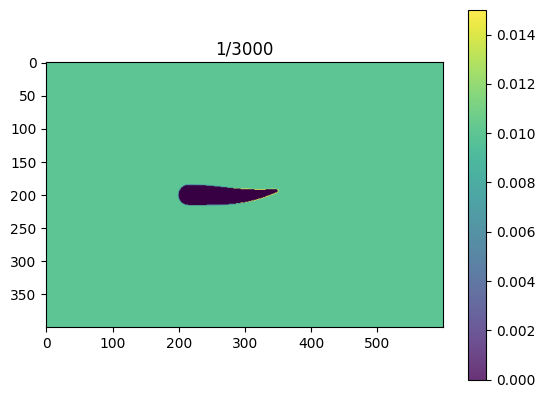

In [ ]:
# Don't animate first few frames
t_start = time.time()
for i in range(fps * nSeconds):
    nN, nE, nS, nW, nNE, nSE, nSW, nNW = stream(nN, nE, nS, nW, nNE, nSE, nSW, nNW)
    # bounce()
    Xbx, Xby, Ubx, Uby = fishboundaryUV(CX, CY, L, i/fps)# 更新鱼轮廓和速度
    ux, uy, n0, nN, nE, nS, nW, nNE, nSE, nSW, nNW = collide(ux, uy, n0, nN, nE, nS, nW, nNE, nSE, nSW, nNW, Xbx, Xby, Ubx, Uby)
    
    if i % 10 == 0:

        # 生成鱼的mask
        fish_contour = []
        for j in range(len(Xbx)):
            fish_contour.append((Xbx[j], Xby[j]))
        immask = generate_curve_mask(fish_contour, img_size=(width, height))
        
        # Plot which we'll be animating
        a = np.sqrt(ux**2 + uy**2)
        a = a.reshape(height,width)
        a[np.where(immask > 0)] = 0
        
        # fig = plt.figure( figsize=(20,5) )
        plt.imshow(immask < 1, cmap='grey')
        plt.imshow(a, vmin = 0, vmax= 0.015, alpha = 0.8)
        plt.colorbar()
        print(i)
        plt.title(str(i+1) + r'/' + str(fps*nSeconds))
        plt.savefig(r'C:\Users\Xiang\Downloads\stream\\' + str(i) + '.png')

        print(i, r'/',fps*nSeconds, r': ', time.time() - t_start)
        print(np.max(Ubx**2), np.max(Uby**2), np.max(a))
        plt.pause(0.1)
